# Phys 512: Assignment 2
## by: Christian Ivanov 260808189

## Question 1
### (a)

I will first use a function (from the course notes) which generates an $ord \times ord$ a matix of chebychev polynomials over a linspace with $n$ sample points to later use in the calculations, making sure $ord$ is large enough so that I can have more freedom in how many terms I later chose to keep when I truncate it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cheb_mat_uniform(nx,ord):
    x=np.linspace(-1,1,nx)
    mat=np.zeros([nx,ord+1])
    mat[:,0]=1.0
    if ord>0:
        mat[:,1]=x
    if ord>1:
        for i in range(1,ord):
            mat[:,i+1]=2*x*mat[:,i]-mat[:,i-1]
    return mat,x

Then, I use this matrix $M$ to fit $log_2 x$ using $\sum_{n=0}^{+\infty} c_n T_n = log_2 x$ where $c_n$ are the coefficients and $T_n$ are the Chebyshev Polynomials of order n.
<br>
As we saw in class, the coefficients in vector form $c$ are given by $c = (M^T M)^{-1} M^T y$ where $y$ is the list of values of $log_2 x$. I will then truncate the series such that the accuracy excedes $10^{-6}$, and also fit the same function with a least squares method for comparison.
<br>
Since chebyshev polynomials only give good fits with minimal error in the $[-1,1]$ range, I scaled and shifted the $[0.5,1]$ interval into it to perform the fitting.

In [3]:
ncoeff=8
n=5000
ord=50
mat,x=cheb_mat_uniform(n,ord)
xx = (x+3)*0.25
y=np.log2(xx)

lhs=np.dot(mat.transpose(),mat)
rhs=np.dot(mat.transpose(),y)
fitp=np.dot(np.linalg.inv(lhs),rhs)
pred=np.dot(mat[:,:ncoeff],fitp[:ncoeff])

lhs2=np.dot(mat[:,:ncoeff].transpose(),mat[:,:ncoeff])
rhs2=np.dot(mat[:,:ncoeff].transpose(),y)
fitp2=np.dot(np.linalg.inv(lhs2),rhs2)
pred2=np.dot(mat[:,:ncoeff],fitp2)

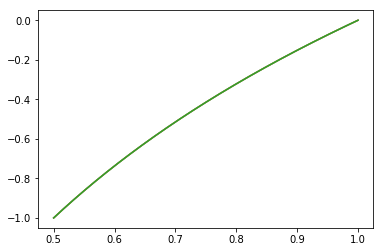

In [4]:
plt.clf();plt.plot(xx,pred);plt.plot(xx,pred2);plt.plot(xx,y);plt.show()

The fit looks pretty good, both the Chebyshev and Least Squares fit are indistinguishable from the original function at a glance.

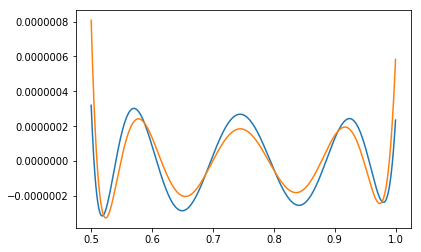

rms error for least-squares is  1.67402205897e-07  with max error  8.07539870862e-07
rms error for chebyshev     is  1.91867544371e-07  with max error  3.19697831541e-07


In [5]:
plt.clf();plt.plot(xx,pred-y);plt.plot(xx,pred2-y);plt.show()
plt.legend(['Chebyshev Residual','Least-Squares Residual'])

print('rms error for least-squares is ',np.sqrt(np.mean((pred2-y)**2)),' with max error ',np.max(np.abs(pred2-y)))
print('rms error for chebyshev     is ',np.sqrt(np.mean((pred-y)**2)),' with max error ',np.max(np.abs(pred-y)))

I used 5000 sample points and a $50 \times 50$ matrix, and after trying out different truncations, I found that 8 terms is the minimum I neeeded to obtain an accuracy of at least $10^{-6}$.
<br>
As we can see from the residuals plot and the error calculations, while Least-Squares is more accurate throughout most of the graph and has a smaller RMS error (as it should, since that's what a Least Square fit does), it is significantly less accurate around the edgges of the plot, and so its max error is much larger. On the other hand, the Chebychev fit has a similar error everywhere, making it much more consistent.

### (b)

From what I understood, I need to extend the chebyshev fit from (a) to work for an interval around any point, and use the fit to estimate the function at that point.
<br>
Note that $log_2 x$ has a singularity at $x = 0$, and so our interval must never contain that point. A good way to avoid that is to scale the interval to the size of the number and center it around that number, which is what I will do. Also note that if we center our interval around our desired point, then in order to evaluate it, our sample points must contain an odd number of points, in which case the middle one will be located at our desired point, and so I will add 1 to the number of sample points if the number entered is even.

In [6]:
def log_function(num,n,ncoeff,ord):
    if (n % 2)==0:
        n = n+1
        
    mat,x=cheb_mat_uniform(n,ord)
    xxx = x*(num/2) + num
    y1=np.log2(xxx)
    mid = int((n-1)/2)

    lhs=np.dot(mat.transpose(),mat)
    rhs=np.dot(mat.transpose(),y1)
    fitp=np.dot(np.linalg.inv(lhs),rhs)
    pred=np.dot(mat[:,:ncoeff],fitp[:ncoeff])

    print ('function value is:',pred[mid])
    print ('error is:',pred[mid]-y1[mid])

In [7]:
log_function(100,n,ncoeff,ord)

function value is: 6.64386525406
error is: 9.06428445635e-06


Using the same matrix size, number of coefficients and sample points as in (a), we obtain a reasonable error of around $9 \times 10^{-6}$ for $Log_2 100$, which seems decent enough and shows that it is working.

## Question 2
### (a)

I will start by plotting the data

In [8]:
data = np.transpose(np.loadtxt('229614158_PDCSAP_SC6.txt',delimiter=','))
temp = data[0]
flux = data[1]

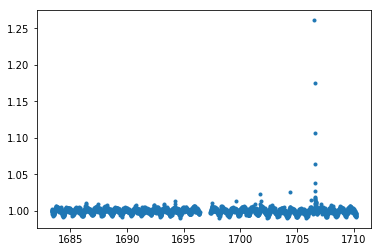

In [9]:
plt.clf();plt.plot(temp,flux,'.');plt.show()

As we can see, the flaring is sharply peaked around some region in time, let's zoom in further

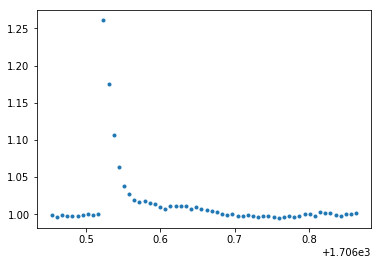

In [10]:
temp1 = temp[3190:3250]
flux1 = flux[3190:3250]
plt.clf();plt.plot(temp1,flux1,'.');plt.show()

We can clearly see that the decay apears to be exponnential from here, so let's adjust the graph to fix exactly in the region of exponential decay

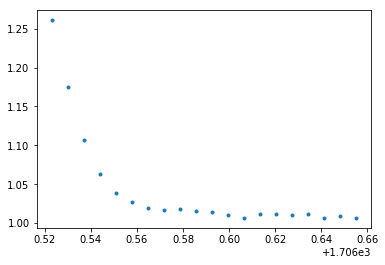

In [11]:
newtemp = temp[3200:3220]
newflux = flux[3200:3220]
plt.clf();plt.plot(newtemp,newflux,'.');plt.show()

We can now use this part of the graph to fit an exponential decay using Newton's method. From the looks of it, I think that a fit of the form $ y = e^{-a(t-b)}+c$ would work best, since it clearly looks lke an exponential function. Looking back at the main graph, we can guess tht $c \approx 1$ and after performing some quick calculations by noticing that the main plot approximately crosses through $y(1706.53) \approx 1.25$ and $y(1706.56) \approx 1.03$, we can see that $a \approx 63$ and $b \approx 1706.5$ are good starting values.

In [12]:
def calc_exp(p,t):
    y=np.exp(p[0]*(p[1]-t))+p[2]
    grad=np.zeros([t.size,p.size])
    grad[:,0]=(p[1]-t)*np.exp(p[0]*(p[1]-t))
    grad[:,1]=p[0]*np.exp(p[0]*(p[1]-t))
    grad[:,2]=1
    return y,grad

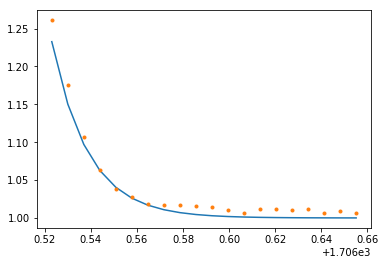

In [13]:
p0=np.array([63,1706.5,1])
guess=np.exp(p0[0]*(p0[1]-newtemp))+p0[2]
plt.clf();plt.plot(newtemp,guess);plt.plot(newtemp,newflux,'.');plt.show()

Indeed, as we can see, our starting guess is reasonably close, but not quite there.

### (b)

Let's run our initial guess through Newton's method. Since our initial guess was already reasonably close, I will start with only 6 iterations.

[  7.12959850e+01   1.70650406e+03   1.00911581e+00] 0.000264113967617
[  7.12959850e+01   1.70650406e+03   1.00911581e+00] 0.000264113967617
[  7.12959850e+01   1.70650406e+03   1.00911581e+00] 0.000264113967617
[  7.12959850e+01   1.70650406e+03   1.00911581e+00] 0.000264113967617
[  7.12959850e+01   1.70650406e+03   1.00911581e+00] 0.000264113967617
[  7.12959850e+01   1.70650406e+03   1.00911581e+00] 0.000264113967617


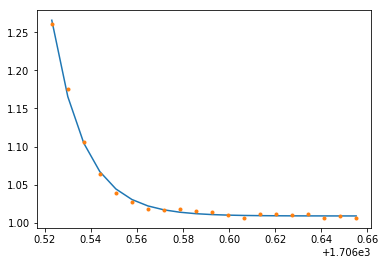

In [15]:
p=p0.copy()
for j in range(6):
    pred,grad=calc_exp(p,newtemp)
    r=newflux-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    print (p,err)
    
plt.clf();plt.plot(newtemp,pred);plt.plot(newtemp,newflux,'.');plt.show()

As we can see, $\chi ^2$ appears to reach a minimum value of about 0.0002641 after only 4 steps, so our initial guess was indeed very good, which is evidenced by how the fit plot visibly passes in-between most of the points.
<br>
The final result after 6 steps is $a = 71.2959849$, $b = 1706.50406$ and $c = 1.00911581$

### (c)

To estimate the error, I will generate random noise which has the same average error as ouroriginal data, add it to the fit and then re-calculate the fit parameters multiple times, taking the standard deviation of each parameter as the error.

In [31]:
avg_err = np.mean(np.abs(pred-newflux))
print(avg_err)

0.00297700157002


In [41]:
samples = 10
param=np.zeros([3,samples])
for i in range(samples):
    for j in range(6):
        new_data = pred + avg_err*np.random.rand(20)
        pred1,grad1=calc_exp(p,newtemp)
        r=new_data-pred1
        err=(r**2).sum()
        r=np.matrix(r).transpose()
        grad1=np.matrix(grad)

        lhs=grad1.transpose()*grad1
        rhs=grad1.transpose()*r
        dp=np.linalg.inv(lhs)*(rhs)
        for jj in range(p.size):
            p[jj]=p[jj]+dp[jj]

        param[0,i]=p[0]
        param[1,i]=p[1]
        param[2,i]=p[2]
        
da = np.std(param[0])
db = np.std(param[1])
dc = np.std(param[2])

print('error in a is',da)
print('error in b is',db)
print('error in c is',dc)

error in a is 0.530238482788
error in b is 0.000167768555043
error in c is 0.000229256339785


After 10 samples, the errors we obtain are roughly 0.53 for a, 0.00017 for b and 0.00023 for c, which all seem fairly reasonable. The largest error is in a, which defines the shape of the exponential, which is normal, as it can vary quite a bit and still fit most of the data. b defines the position of the flare in the data and c defines the minimal value of the flux, both of which are very well defined and so it is normal that their errors are very small.

### (d)

Looking at the data as a whole, we can see that there appears to be a regular oscilation of the intensity as a function of time, which may still be present even duing the flaring event we are trying to model, and so even if our fit parameter errors are small, they will miss the underlying effect of this oscilation. A better way to do this would be to model the oscilations separately and then subtract them from the data set we plotted the flaring on, and them re-fitting the new data set without the oscilations.